# Прекод

# Сборный проект-4

Вам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

### Описание данных

Данные доступны по [ссылке](https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip).

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

## 1. Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Вы можете воспользоваться другим методом агрегации оценок или придумать свой.

В файле с краудсорсинговыми оценками информация расположена в таком порядке:

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке.
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберите либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Ваша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.


Установим необходимые библиотеки:

In [1]:
 !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124

Looking in indexes: https://download.pytorch.org/whl/cu124

[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [2]:
!pip install pandas matplotlib seaborn wordcloud nltk transformers tqdm ipywidgets scikit-learn


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


Импортируем библиотеки:

In [3]:
import os
import zipfile
from pathlib import Path

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import transformers
from PIL import Image
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from torchvision import models, transforms
from torchvision.models import ResNet50_Weights
from tqdm import notebook, tqdm
from wordcloud import WordCloud

# instantiate
tqdm.pandas()

nltk.download('punkt_tab')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

DATASET_PATH = './dataset_search'
TRAIN_IMAGE_PATH = './dataset_search/to_upload/train_images'
TEST_IMAGE_PATH = './dataset_search/to_upload/test_images'

[nltk_data] Downloading package punkt_tab to /home/runx/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
/home/runx/misc/PycharmProjects/image_find/.venv/lib/python3.11/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


Код для загрузки исходных данных:

In [4]:
def download_dataset():
    base_url = 'https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip'

    download_response = requests.get(base_url)
    with open('./data.zip', 'wb') as f:
        f.write(download_response.content)

    zip_path = './data.zip'

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(DATASET_PATH)

In [5]:
if not Path('./dataset_search').exists():
    download_dataset()

Прочитаем предоставленные данные:

In [6]:
train_dataset_df = pd.read_csv(os.path.join(DATASET_PATH, 'to_upload/train_dataset.csv'))
crowd_annotations_df = pd.read_csv(os.path.join(DATASET_PATH, 'to_upload/CrowdAnnotations.tsv'), sep='\t', header=None,
                                   names=["image", "query_id",
                                          "matches_image_ratio",
                                          "matches_count",
                                          "not_matches_count"])
expert_annotations_df = pd.read_csv(os.path.join(DATASET_PATH, 'to_upload/ExpertAnnotations.tsv'), sep='\t',
                                    header=None,
                                    names=["image", "query_id",
                                           "expert_1",
                                           "expert_2",
                                           "expert_3"])
test_queries_df = pd.read_csv(os.path.join(DATASET_PATH, 'to_upload/test_queries.csv'), sep='|', index_col=0)
test_images_df = pd.read_csv(os.path.join(DATASET_PATH, 'to_upload/test_images.csv'), sep='|')

Напишем функцию для просмотра данных:

In [7]:
def show_info(df, name):
    print(name)
    display(df.head(5))
    df.info()
    print("\n")

In [8]:
show_info(train_dataset_df, "train_dataset")
show_info(crowd_annotations_df, "CrowdAnnotations")
show_info(expert_annotations_df, "ExpertAnnotations")
show_info(test_queries_df, "test_queries")
show_info(test_images_df, "test_images")

train_dataset


,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


CrowdAnnotations


,image,query_id,matches_image_ratio,matches_count,not_matches_count
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.0,0,3
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.0,0,3
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.0,0,3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   image                47830 non-null  object 
 1   query_id             47830 non-null  object 
 2   matches_image_ratio  47830 non-null  float64
 3   matches_count        47830 non-null  int64  
 4   not_matches_count    47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


ExpertAnnotations


,image,query_id,expert_1,expert_2,expert_3
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   expert_1  5822 non-null   int64 
 3   expert_2  5822 non-null   int64 
 4   expert_3  5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.6+ KB


test_queries


,query_id,query_text,image
0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg
2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg
3,1177994172_10d143cb8d.jpg#3,Two children wearing jeans squirt water at eac...,1177994172_10d143cb8d.jpg
4,1177994172_10d143cb8d.jpg#4,Two young boys are squirting water at each oth...,1177994172_10d143cb8d.jpg


<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


test_images


,image
0,3356748019_2251399314.jpg
1,2887171449_f54a2b9f39.jpg
2,3089107423_81a24eaf18.jpg
3,1429546659_44cb09cbe2.jpg
4,1177994172_10d143cb8d.jpg


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   100 non-null    object
dtypes: object(1)
memory usage: 932.0+ bytes




Посмотрим на количество уникальных изображений:

In [9]:
def unique_images(name, df):
    print(f"Количество уникальных изображений в {name}:", len(df.image.unique()))

In [10]:
unique_images("Данные для обучения", train_dataset_df)
unique_images("Данные для теста", test_images_df)

Количество уникальных изображений в Данные для обучения: 1000
Количество уникальных изображений в Данные для теста: 100


In [11]:
unique_images("Данные от краудсорсинга", crowd_annotations_df)
unique_images("Данные от экспертов", expert_annotations_df)

Количество уникальных изображений в Данные от краудсорсинга: 1000
Количество уникальных изображений в Данные от экспертов: 1000


Посмотрим количество уникальных текстов:

In [12]:
def unique_text(name, df):
    print(f"Количество уникальных текстов в {name}:", len(df.query_id.unique()))

In [13]:
unique_text("Данные для обучения", train_dataset_df)
unique_text("Данные для теста", test_queries_df)

Количество уникальных текстов в Данные для обучения: 977
Количество уникальных текстов в Данные для теста: 500


In [14]:
unique_text("Данные от краудсорсинга", crowd_annotations_df)
unique_text("Данные от экспертов", expert_annotations_df)

Количество уникальных текстов в Данные от краудсорсинга: 1000
Количество уникальных текстов в Данные от экспертов: 977


Вычислим среднее значение мнений экспертов и нормализуем его:

In [15]:
def convert_ratings_to_normalized_score(rating1, rating2, rating3):
    ratings = [rating1, rating2, rating3]
    average_rating = sum(ratings) / len(ratings)
    normalized_score = (average_rating - 1) / 3
    return normalized_score


expert_annotations_df['normalized_expert'] = expert_annotations_df.apply(
    lambda row: convert_ratings_to_normalized_score(row['expert_1'], row['expert_2'], row['expert_3']),
    axis=1
)
expert_annotations_df.head(5)

,image,query_id,expert_1,expert_2,expert_3,normalized_expert
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1,0.000000
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2,0.111111
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2,0.111111
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2,0.222222
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2,0.111111


Построим график распределения экспертных оценок по полю `normalized_expert`:

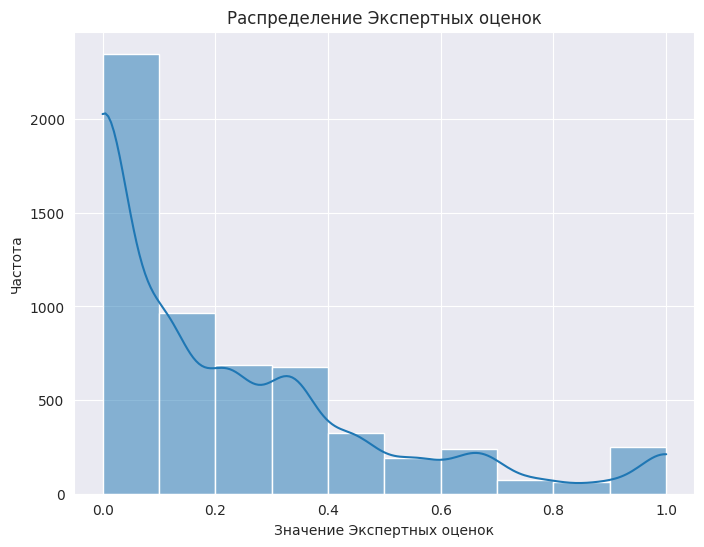

In [16]:
plt.figure(figsize=(8, 6))
sns.histplot(expert_annotations_df['normalized_expert'], bins=10, kde=True)
plt.title('Распределение Экспертных оценок')
plt.xlabel('Значение Экспертных оценок')
plt.ylabel('Частота')
plt.show()

Построим график распределения оценок полученных краудсорсингом по полю `matches_image_ratio`:

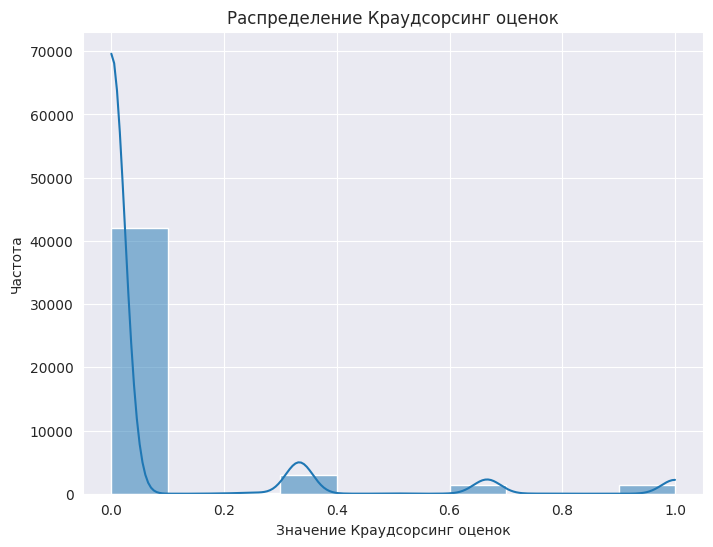

In [17]:
plt.figure(figsize=(8, 6))
sns.histplot(crowd_annotations_df['matches_image_ratio'], bins=10, kde=True)
plt.title('Распределение Краудсорсинг оценок')
plt.xlabel('Значение Краудсорсинг оценок')
plt.ylabel('Частота')
plt.show()

Оценки полученные от краудсорсинга менее вариативны, в границах от 0 и до 1.

Выведем изображения на экран:

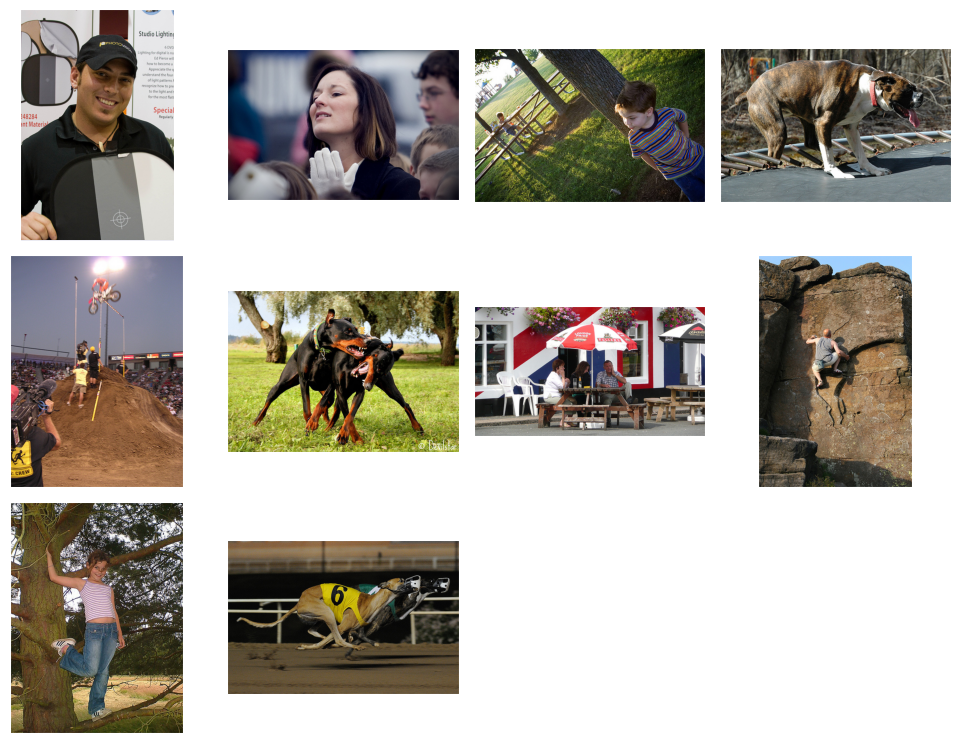

In [18]:
train_images = list(train_dataset_df['image'].sample(10))

fig = plt.figure(figsize=(10, 10))
for i in range(10):
    fig.add_subplot(4, 4, i + 1)
    plt.imshow(Image.open(os.path.join(TRAIN_IMAGE_PATH, train_images[i])))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

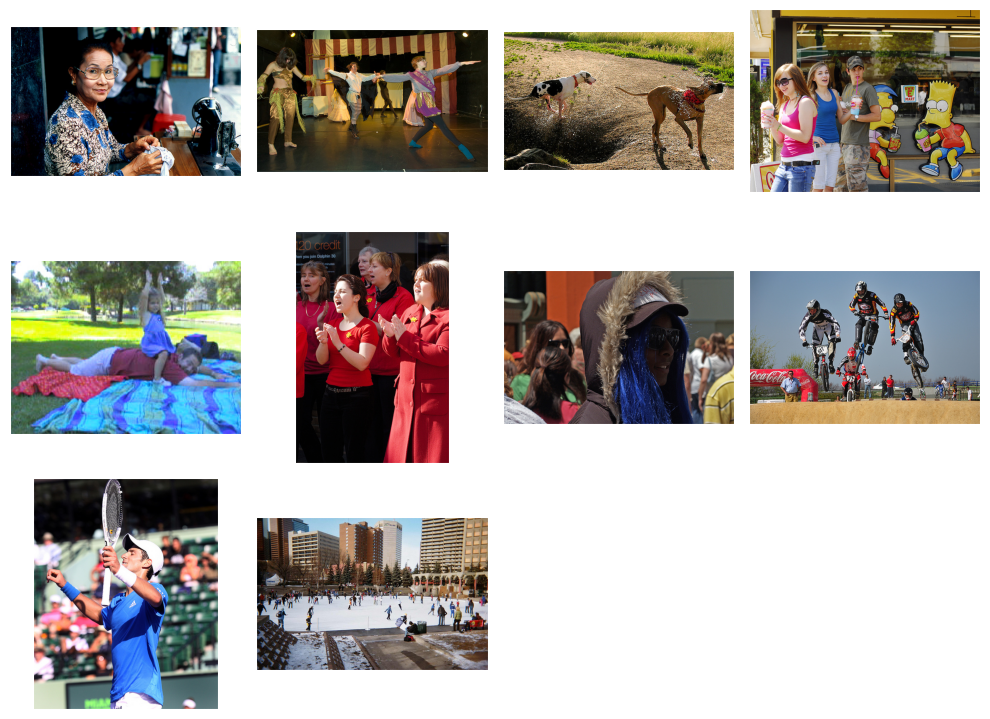

In [19]:
test_images = list(test_images_df['image'].sample(10))

fig = plt.figure(figsize=(10, 10))
for i in range(10):
    fig.add_subplot(4, 4, i + 1)
    plt.imshow(Image.open(os.path.join(TEST_IMAGE_PATH, test_images[i])))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Проведем частотный анализ текста используя облако слов:

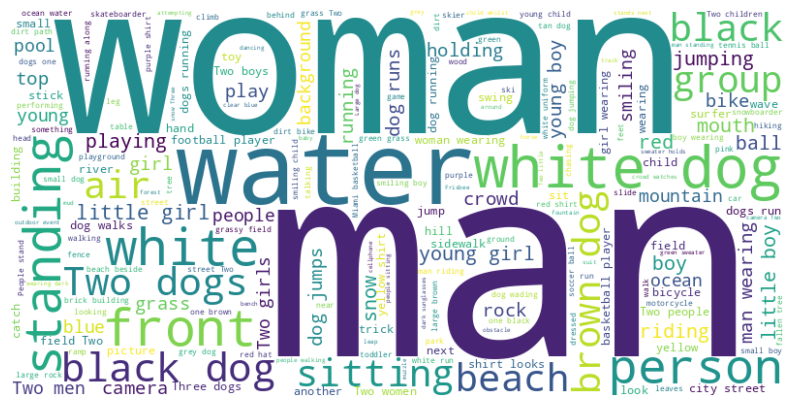

In [20]:
# Объединяем все тексты в один большой текст
text = " ".join(txt for txt in train_dataset_df['query_text'])

# Создаем объект WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Визуализируем wordcloud 
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Из данных экспертов удалим оценки, оставим нормализованное значение:

### Создание датасета

Удалим колонки с оценками экспертов, оставим нормализованное значение:

In [21]:
expert_annotations_df = expert_annotations_df.drop(['expert_1', 'expert_2', 'expert_3'], axis=1)
expert_annotations_df.head(3)

,image,query_id,normalized_expert
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,0.000000
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,0.111111
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,0.111111


In [22]:
crowd_annotations_df = crowd_annotations_df.drop(['matches_count', 'not_matches_count'], axis=1)
crowd_annotations_df.head(3)

,image,query_id,matches_image_ratio
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.0


In [23]:
temp_annotations_df = pd.merge(expert_annotations_df,
                               crowd_annotations_df,
                               how='left',
                               left_on=['image', 'query_id'],
                               right_on=['image', 'query_id'])
temp_annotations_df.info()
temp_annotations_df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   image                5822 non-null   object 
 1   query_id             5822 non-null   object 
 2   normalized_expert    5822 non-null   float64
 3   matches_image_ratio  2329 non-null   float64
dtypes: float64(2), object(2)
memory usage: 182.1+ KB


,image,query_id,normalized_expert,matches_image_ratio
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,0.000000,0.0
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,0.111111,0.0
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,0.111111,NaN
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,0.222222,NaN
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,0.111111,NaN


In [24]:
print(temp_annotations_df.isna().sum())

image                     0
query_id                  0
normalized_expert         0
matches_image_ratio    3493
dtype: int64


Заполним пропуски в `matches_image_ration` значением 0.5 и будем использовать для неё меньший вес:

In [25]:
temp_annotations_df['matches_image_ratio'] = temp_annotations_df['matches_image_ratio'].fillna(0.5)
print(temp_annotations_df.isna().sum())

image                  0
query_id               0
normalized_expert      0
matches_image_ratio    0
dtype: int64


Посчитаем итоговое экспертное значение как 0.8 экспертным оценкам и 0.2 пользовательским:

In [26]:
def expert_value(expert_value_, crowd_value_):
    return 0.8 * expert_value_ + 0.2 * crowd_value_


temp_annotations_df['expert_value'] = temp_annotations_df.apply(
    lambda row: expert_value(row['normalized_expert'], row['matches_image_ratio']),
    axis=1
)
temp_annotations_df.head(5)

,image,query_id,normalized_expert,matches_image_ratio,expert_value
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,0.000000,0.0,0.000000
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,0.111111,0.0,0.088889
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,0.111111,0.5,0.188889
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,0.222222,0.5,0.277778
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,0.111111,0.5,0.188889


Сделаем датасет для обучения:

In [27]:
train_dataset_df = pd.merge(train_dataset_df,
                            temp_annotations_df[['image', 'query_id', 'expert_value']],
                            how='left',
                            left_on=['image', 'query_id'],
                            right_on=['image', 'query_id'])
train_dataset_df.info()
train_dataset_df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   image         5822 non-null   object 
 1   query_id      5822 non-null   object 
 2   query_text    5822 non-null   object 
 3   expert_value  5822 non-null   float64
dtypes: float64(1), object(3)
memory usage: 182.1+ KB


,image,query_id,query_text,expert_value
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.000000
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.100000
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.177778
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1.000000
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.100000


In [28]:
print(train_dataset_df.isna().sum())

image           0
query_id        0
query_text      0
expert_value    0
dtype: int64


## 2. Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
>

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

Используя частотный анализ составим список слов относящиеся к детям и добавим свои слова:

In [29]:
forbidden_worlds = ['girl', 'boy', 'young', 'little', 'toddler', 'children'] + ['child', 'kid', 'teen', 'infant',
                                                                                'adolescent', 'minor']
forbidden_worlds

['girl',
 'boy',
 'young',
 'little',
 'toddler',
 'children',
 'child',
 'kid',
 'teen',
 'infant',
 'adolescent',
 'minor']

Напишем функцию для поиска запрещенных слов:

In [30]:
def find_forbidden_words(sentence):
    stemmer = PorterStemmer()
    tokens = word_tokenize(sentence.lower())
    stemmed_forbidden = {stemmer.stem(word) for word in forbidden_worlds}
    found_words = {token for token in tokens if stemmer.stem(token) in stemmed_forbidden}
    if len(list(found_words)) > 0:
        return 1
    else:
        return 0

In [31]:
train_dataset_df['forbidden'] = train_dataset_df.apply(
    lambda row: find_forbidden_words(row['query_text']),
    axis=1
)
train_dataset_df.head(5)

,image,query_id,query_text,expert_value,forbidden
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.000000,1
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.100000,1
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.177778,1
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1.000000,1
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.100000,1


In [32]:
train_dataset_df = train_dataset_df[train_dataset_df['forbidden'] != 1]
train_dataset_df = train_dataset_df.drop(['forbidden'], axis=1)
train_dataset_df.info()
train_dataset_df.head(5)

<class 'pandas.core.frame.DataFrame'>
Index: 4219 entries, 22 to 5821
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   image         4219 non-null   object 
 1   query_id      4219 non-null   object 
 2   query_text    4219 non-null   object 
 3   expert_value  4219 non-null   float64
dtypes: float64(1), object(3)
memory usage: 164.8+ KB


,image,query_id,query_text,expert_value
22,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,0.188889
23,3187395715_f2940c2b72.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,0.277778
24,463978865_c87c6ca84c.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,0.266667
25,488590040_35a3e96c89.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,0.277778
26,534875358_6ea30d3091.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,0.188889


## 3. Векторизация изображений

Перейдём к векторизации изображений.

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

In [33]:
resnet50 = models.resnet50(weights=ResNet50_Weights.DEFAULT)
resnet50.fc = nn.Identity()  # Убираем последний слой
resnet50.to(device)
resnet50.eval()

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [34]:
def vectorize_image(image_path, path):
    image = Image.open(os.path.join(path, image_path)).convert('RGB')
    image = preprocess(image)
    image = image.unsqueeze(0).to(device)

    with torch.no_grad():
        features = resnet50(image)

    return pd.Series(features.flatten().cpu().numpy())

In [35]:
def get_image_embedding(column, path):
    emd = column.progress_apply(lambda x: vectorize_image(x, path))
    embeddings = []
    for i in emd:
        embeddings.append(emd[i])
    return pd.DataFrame(embeddings).to_numpy().T

In [36]:
image_embedding = get_image_embedding(train_dataset_df['image'], TRAIN_IMAGE_PATH)

100%|██████████| 4219/4219 [04:40<00:00, 15.02it/s]


## 4. Векторизация текстов

Следующий этап — векторизация текстов. Вы можете поэкспериментировать с несколькими способами векторизации текстов:

- tf-idf
- word2vec
- \*трансформеры (например Bert)

\* — если вы изучали трансформеры в спринте Машинное обучение для текстов.


In [37]:
tokenizer = transformers.BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = transformers.BertModel.from_pretrained("bert-base-uncased")
bert_model = bert_model.to(device)

In [38]:
def get_text_embedding(column):
    tokenized = column.apply(
        lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=512, truncation=True))

    max_len = 0
    for i in tokenized.values:
        if len(i) > max_len:
            max_len = len(i)

    padded = np.array([i + [0] * (max_len - len(i)) for i in tokenized.values])

    attention_mask = np.where(padded != 0, 1, 0)
    batch_size = 100
    embeddings = []
    num_samples = padded.shape[0]

    for i in notebook.tqdm(range(0, num_samples, batch_size)):
        end_idx = min(i + batch_size, num_samples)
        batch = torch.LongTensor(padded[i:end_idx]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask[i:end_idx]).to(device)

        with torch.no_grad():
            batch_embeddings = bert_model(batch, attention_mask=attention_mask_batch)

        embeddings.append(batch_embeddings[0][:, 0, :].cpu().numpy())

    return np.concatenate(embeddings, axis=0)

In [39]:
text_embedding = get_text_embedding(train_dataset_df['query_text'])

  0%|          | 0/43 [00:00<?, ?it/s]

## 5. Объединение векторов

Подготовьте данные для обучения: объедините векторы изображений и векторы текстов с целевой переменной.

In [40]:
text_embedding.shape

(4219, 768)

In [41]:
image_embedding.shape

(4219, 2048)

In [42]:
combined_embedding = np.hstack((text_embedding, image_embedding))
combined_embedding.shape

(4219, 2816)

In [43]:
final_train_dataset_df = pd.DataFrame(combined_embedding)
final_train_dataset_df['expert_value'] = train_dataset_df['expert_value'].values
final_train_dataset_df['image'] = train_dataset_df['image'].values
final_train_dataset_df.shape

(4219, 2818)

## 6. Обучение модели предсказания соответствия

Для обучения разделите датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, можно воспользоваться классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.

Код ниже разбивает датасет на тренировочную и тестовую выборки в пропорции 7:3 так, что строки с одинаковым значением 'group_column' будут содержаться либо в тестовом, либо в тренировочном датасете.

```
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['target']), y=df['target'], groups=df['group_column']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]

```

Какую модель использовать — выберите самостоятельно. Также вам предстоит выбрать метрику качества либо реализовать свою.

In [44]:
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=final_train_dataset_df.drop(columns=['expert_value', 'image']),
                                             y=final_train_dataset_df['expert_value'],
                                             groups=final_train_dataset_df['image']))
train_df, test_df = final_train_dataset_df.loc[train_indices], final_train_dataset_df.loc[test_indices]

In [45]:
X_train = train_df.drop(['expert_value', 'image'], axis=1)
y_train = train_df['expert_value']

X_test = test_df.drop(['expert_value', 'image'], axis=1)
y_test = test_df['expert_value']

# Нормализация данных
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test.to_numpy(), dtype=torch.float32).view(-1, 1)

In [48]:
# Линейная регрессия
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim, dropout_rate=0.5):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.dropout(x)  # применяется Dropout к входным данным
        return self.linear(x)


# Гиперпараметры
input_dim = X_train.shape[1]  # допустим, X_train и y_train уже определены
dropout_rate = 0.5
model = LinearRegressionModel(input_dim, dropout_rate).to(device)  # перемещаем модель на GPU
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Перемещаем данные на устройство
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Обучение
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}')

# Оценка
model.eval()
with torch.no_grad():
    predictions = model(X_test)
    mse = mean_squared_error(y_test.cpu(), predictions.cpu())  # перемещение данных обратно на CPU для оценки
    print(f'Validation MSE: {mse:.4f}')

Epoch [0/100], Loss: 0.7673
Epoch [10/100], Loss: 0.8390
Epoch [20/100], Loss: 0.3332
Epoch [30/100], Loss: 0.1580
Epoch [40/100], Loss: 0.0809
Epoch [50/100], Loss: 0.0635
Epoch [60/100], Loss: 0.0540
Epoch [70/100], Loss: 0.0461
Epoch [80/100], Loss: 0.0442
Epoch [90/100], Loss: 0.0425
Validation MSE: 0.0472


In [64]:
# Полносвязная нейронная сеть
class FullyConnectedNN(nn.Module):
    def __init__(self, input_dim, dropout_rate=0.5):
        super(FullyConnectedNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_rate)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)  # применяем dropout после relu
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)  # применяем dropout после relu
        x = self.fc3(x)
        return x


# Гиперпараметры
input_dim = X_train.shape[1]
dropout_rate = 0.2
model = FullyConnectedNN(input_dim, dropout_rate).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # настройка lr

# Перемещаем данные на устройство
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Обучение
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}')

# Оценка
model.eval()
with torch.no_grad():
    predictions = model(X_test)
    mse = mean_squared_error(y_test.cpu(), predictions.cpu())  # перемещение данных обратно на CPU для оценки
    print(f'Validation MSE: {mse:.4f}')

Epoch [0/100], Loss: 0.1276
Epoch [10/100], Loss: 0.0365
Epoch [20/100], Loss: 0.0252
Epoch [30/100], Loss: 0.0192
Epoch [40/100], Loss: 0.0153
Epoch [50/100], Loss: 0.0132
Epoch [60/100], Loss: 0.0107
Epoch [70/100], Loss: 0.0098
Epoch [80/100], Loss: 0.0088
Epoch [90/100], Loss: 0.0084
Validation MSE: 0.0400


## 7. Тестирование модели

Настало время протестировать модель. Для этого получите эмбеддинги для всех тестовых изображений из папки `test_images`, выберите случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведите наиболее релевантное изображение. Сравните визуально качество поиска.

In [65]:
image_embedding_test = get_image_embedding(test_queries_df['image'], TEST_IMAGE_PATH)
text_embedding_test = get_text_embedding(test_queries_df['query_text'])

TypeError: 'numpy.ndarray' object is not callable

## 8. Выводы

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Исследовательский анализ данных выполнен
- [ ]  Проверены экспертные оценки и краудсорсинговые оценки
- [ ]  Из датасета исключены те объекты, которые выходят за рамки юридических ограничений
- [ ]  Изображения векторизованы
- [ ]  Текстовые запросы векторизованы
- [ ]  Данные корректно разбиты на тренировочную и тестовую выборки
- [ ]  Предложена метрика качества работы модели
- [ ]  Предложена модель схожести изображений и текстового запроса
- [ ]  Модель обучена
- [ ]  По итогам обучения модели сделаны выводы
- [ ]  Проведено тестирование работы модели
- [ ]  По итогам тестирования визуально сравнили качество поиска